In [463]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retail-sales-clothing-clothing-accessory-stores/RSCCASN.csv


In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [465]:
df = pd.read_csv('../input/retail-sales-clothing-clothing-accessory-stores/RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [466]:
df.columns = ['Sales']

In [467]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


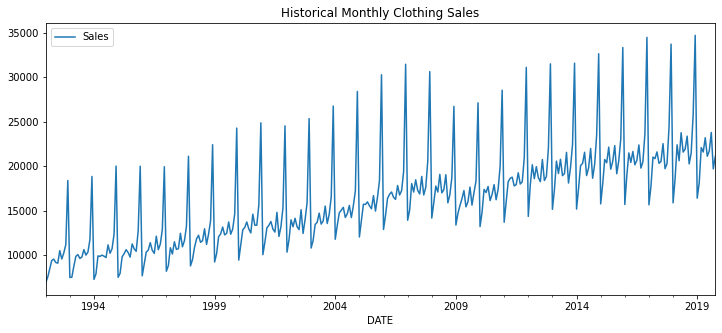

In [468]:
df.plot(figsize=(12, 5), title='Historical Monthly Clothing Sales');

In [469]:
df.shape

(334, 1)

In [470]:
df.dtypes

Sales    int64
dtype: object

In [471]:
test_size = 18 # Set to 18 months to capture the seasonality
test_split_ind = len(df) - test_size
train = df[:test_split_ind]
test = df[test_split_ind:]

In [472]:
from sklearn.preprocessing import MinMaxScaler

In [473]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [474]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [475]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [476]:
X0, y0 = generator[0]

In [477]:
X0.shape, y0.shape

((1, 12, 1), (1, 1))

In [478]:
print(X0)
print(y0)

[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]
[[0.02047633]]


In [479]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [480]:
n_features = 1

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [481]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [482]:
from tensorflow.keras.callbacks import EarlyStopping

In [483]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [484]:
val_generator = TimeseriesGenerator(data=scaled_test, 
                                    targets=scaled_test, 
                                    length=length,
                                    batch_size=batch_size)

In [485]:
model.fit_generator(generator=generator, 
                    epochs=20,
                    callbacks=[early_stopping],
                    validation_data=val_generator)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


304/304 [==============================] - 3s 7ms/step - loss: 0.0578 - val_loss: 0.0150
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0258 - val_loss: 0.0172
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0098 - val_loss: 0.0199
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0051 - val_loss: 3.8026e-04
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0108


In [486]:
stopped_epoch = early_stopping.stopped_epoch
stopped_epoch

7

<AxesSubplot:>

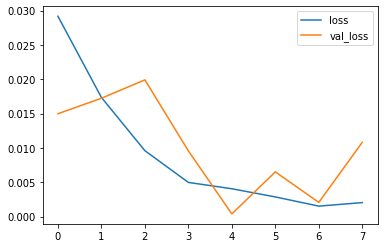

In [487]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [488]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    # get the prediction of 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # Store prediction
    test_predictions.append(current_pred)
    
    # Update batch to include the latest prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:], 
                              [[current_pred]],
                              axis=1) 
    

In [489]:
true_predictions = scaler.inverse_transform(test_predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

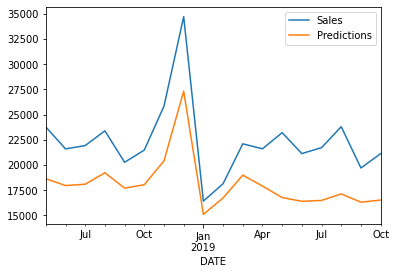

In [490]:
test['Predictions'] = true_predictions
test.plot()

In [491]:
full_scaler = MinMaxScaler()

scaled_df = full_scaler.fit_transform(df)

In [492]:
length = 12
batch_size =1 

df_generator = TimeseriesGenerator(data=scaled_df, 
                                   targets=scaled_df,
                                   length=length,
                                   batch_size=batch_size)

In [493]:
n_features = 1

model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [494]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [495]:
model.fit_generator(df_generator, epochs=stopped_epoch)

Epoch 1/7


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


322/322 [==============================] - 3s 6ms/step - loss: 0.0362
Epoch 2/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0177
Epoch 3/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0071
Epoch 4/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0086
Epoch 5/7
322/322 [==============================] - 2s 5ms/step - loss: 0.0030
Epoch 6/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 7/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0022


In [496]:
scaled_forecasts = []

first_batch = scaled_df[-length:]

current_batch = first_batch.reshape((1,length,n_features))

periods = 12

for _ in range(periods):
    
    current_pred = model.predict(current_batch)[0]
    
    scaled_forecasts.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [497]:
forecasts = full_scaler.inverse_transform(scaled_forecasts)

In [498]:
ind_start = df.index.max()
ind_start = ind_start + pd.DateOffset(months=1)
ind_start

Timestamp('2019-11-01 00:00:00')

In [499]:
dti = pd.date_range(start=ind_start, periods=periods, freq='MS')
dti

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [500]:
forecasts_df = pd.DataFrame(forecasts, index=dti, columns=['Sales'])
forecasts_df['flag'] = 'forecast'
df['flag'] = 'train'

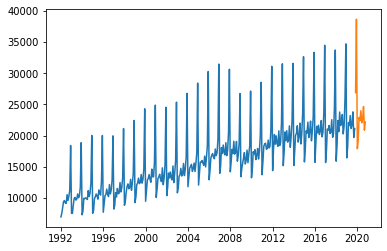

In [501]:
fig, ax = plt.subplots()
ax.plot(df['Sales'])
ax.plot(forecasts_df['Sales'])
ax.autoscale()

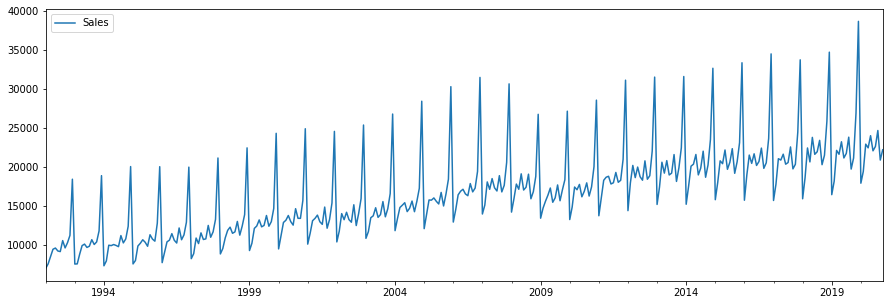

In [502]:
full_df = df.append(forecasts_df)
full_df.plot(figsize=(15, 5));